![](https://images.pexels.com/photos/1077327/pexels-photo-1077327.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)

# Magnetometer Calibration

To calibrate a magnetometer, you need to get readings from all directions in 3D space. Ideally, when you plot the readings out, you should get a perfect sphere centered at (0,0,0). However, due to misalignments, offset, etc ... you end up with ellipsoids centered at some biased location.

Here we are going to try and get enough readings to estimate these errors and properly calibrate the sensor. We will load in a pre-recorded data set, where the sensor was tumbled around and calibrate it.

## References

- [Teslabs: Magnetometer Calibration](https://teslabs.com/articles/magnetometer-calibration/)
- [ThePoorEngineer: Calibrating the Magnetometer](https://www.thepoorengineer.com/en/calibrating-the-magnetometer/)

In [1]:
import numpy as np # matrix manipulations
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

from scipy import linalg
import sys

import the_collector # read data
print(f"the-collector: {the_collector.__version__}")

from the_collector import BagIt
from the_collector import Pickle, Json

from squaternion import Quaternion

import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

# from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

from slurm import storage

from datetime import datetime
import os

the-collector: 0.8.7


In [2]:
# let's load in some data and have a look at what we have
def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')

bag = BagIt(Pickle)
fname = "~/github/data-ins-1/2020-5-3-imu/tumble.pickle.bag"
fname = os.path.expanduser(fname)

data = bag.read(fname)
bag_info(data)

>> Reading[pickle]: /Users/kevin/github/data-ins-1/2020-5-3-imu/tumble.pickle.bag
Bag keys:
--------------------------------------------------
       accel: 3193   
         mag: 3193   
        gyro: 3193   


In [3]:
# data is an array of IMU messages
def get(bag, key):
    data = {"x":[], "y":[],"z":[],"ts":[]}
    for (x,y,z),ts in bag[key]:
        data["x"].append(x)
        data["y"].append(y)
        data["z"].append(z)
        data["ts"].append(ts)
    return data

def get_np(bag, key):
    xx = []
    yy = []
    zz = []
    for (x,y,z),ts in bag[key]:
        xx.append(x)
        yy.append(y)
        zz.append(z)
    return np.array(xx), np.array(yy), np.array(zz)

mag = get_np(data, "mag")

mdf = pd.DataFrame(get(data, "mag"))
mx,my,mz,_ = mdf.mean()
# mdf.std()

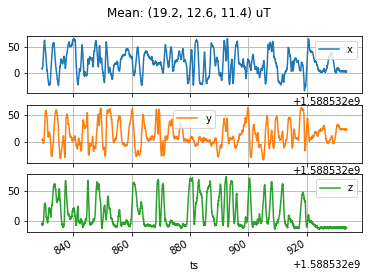

In [4]:
mdf.plot(x="ts", grid=True, subplots=True, title=f"Mean: ({mx:.1f}, {my:.1f}, {mz:.1f}) uT");

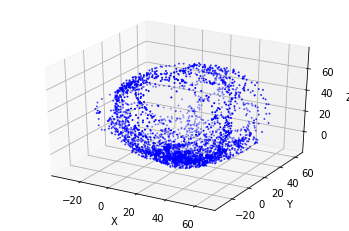

In [5]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111, projection='3d')

ax1.scatter(mag[0], mag[1], mag[2], s=1, color='b')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z');

# Calibrate

In [6]:
def calibrate(s, F=1):
    ''' Performs calibration of magnetometer data by performing an 
    elliptical fit of the data. 
    
    F: expected field strength, default is 1
    Returns: an A and b matrix, such that, actual_mag = A*noisy_mag + b
    '''
    s = s.T
    
    # D (samples)
    D = np.array([
        s[0]**2., s[1]**2., s[2]**2.,
        2.*s[1]*s[2], 2.*s[0]*s[2], 2.*s[0]*s[1],
        2.*s[0], 2.*s[1], 2.*s[2], np.ones_like(s[0])])

    # S, S_11, S_12, S_21, S_22 (eq. 11)
    S = np.dot(D, D.T)
    S_11 = S[:6,:6]
    S_12 = S[:6,6:]
    S_21 = S[6:,:6]
    S_22 = S[6:,6:]

    # C (Eq. 8, k=4)
    C = np.array([[-1,  1,  1,  0,  0,  0],
                  [ 1, -1,  1,  0,  0,  0],
                  [ 1,  1, -1,  0,  0,  0],
                  [ 0,  0,  0, -4,  0,  0],
                  [ 0,  0,  0,  0, -4,  0],
                  [ 0,  0,  0,  0,  0, -4]])

    # v_1 (eq. 15, solution)
    E = np.dot(
        linalg.inv(C),
        S_11 - np.dot(S_12, np.dot(linalg.inv(S_22), S_21)))

    E_w, E_v = np.linalg.eig(E)

    v_1 = E_v[:, np.argmax(E_w)]
    if v_1[0] < 0: v_1 = -v_1

    # v_2 (eq. 13, solution)
    v_2 = np.dot(np.dot(-np.linalg.inv(S_22), S_21), v_1)

    # quadric-form parameters
    M = np.array([[v_1[0], v_1[3], v_1[4]],
                  [v_1[3], v_1[1], v_1[5]],
                  [v_1[4], v_1[5], v_1[2]]])
    n = np.array([[v_2[0]],
                  [v_2[1]],
                  [v_2[2]]])
    d = v_2[3]

    #-------------------------------------
    # calibration parameters
    # note: some implementations of sqrtm return complex type, taking real
    M_1 = linalg.inv(M)
    b = -np.dot(M_1, n).T[0]  # make numpy array [bx,by,bz]

    A = F / np.sqrt(np.abs(np.dot(n.T, np.dot(M_1, n)) - d)) 
    A = A*np.real(linalg.sqrtm(M))

    return A, b

In [7]:
# https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm
# uT
uT = 50.8862

In [8]:
def get_list(bag, key):
    d = []
    dt = []
    last = None
    for v,ts in bag[key]:
        d.append(v)
        if last is None:
            last = ts
        else:
            dt.append(ts - last)
            last=ts
    return np.array(d), np.mean(dt)

magg, dt = get_list(data, "mag")

In [9]:
# (array([[ 1.13607723,  0.01426521, -0.01018889],
#         [ 0.01426521,  1.14363401, -0.00629215],
#         [-0.01018889, -0.00629215,  1.23403399]]),
#  array([20.28337018, 16.52551857, 29.55239641]))
A, b = calibrate(magg, uT)
print(f">> A:\n{A}")
print(f">> b: {b}")

>> A:
[[ 1.136  0.014 -0.01 ]
 [ 0.014  1.144 -0.006]
 [-0.01  -0.006  1.234]]
>> b: [20.283 16.526 29.552]


In [10]:
orig = magg
cm=(np.dot(A,(magg-b).T)).T

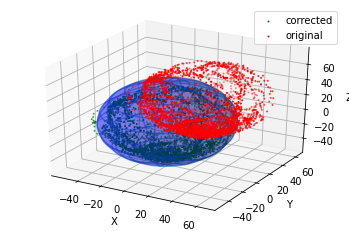

In [24]:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111, projection='3d')

ax1.scatter([x[0] for x in cm],[x[1] for x in cm],[x[2] for x in cm], s=1, color='g',label="corrected")
ax1.scatter([x[0] for x in orig],[x[1] for x in orig],[x[2] for x in orig], s=1, color='r', label="original")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# plot unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = uT*np.outer(np.cos(u), np.sin(v))
y = uT*np.outer(np.sin(u), np.sin(v))
z = uT*np.outer(np.ones(np.size(u)), np.cos(v))
ax1.plot_wireframe(x, y, z, rstride=10, cstride=10, alpha=0.5)
ax1.plot_surface(x, y, z, alpha=0.3, color='b')

ax1.legend()
plt.show();

In [25]:
error = 0
for v in cm:
    error += np.linalg.norm(v)-uT
print(error/len(cm))

-8.07982705069158


In [17]:
ans=(np.dot(A,(magg-b).T)).T

error = 0
for v in ans:
    error += np.linalg.norm(v)-uT
print(error/len(ans))

-0.00555081379273808


In [18]:
def plotMagnetometer(data, title=None):
    x = [v[0] for v in data]
    y = [v[1] for v in data]
    z = [v[2] for v in data]
    plt.plot(x,y,'.b', x,z,'.r', z,y, '.g')
    plt.xlabel('$\mu$T')
    plt.ylabel('$\mu$T')
    plt.grid(True);
    plt.axis('equal')
    plt.legend(['x', 'y', 'z'])
    if title:
        plt.title(title);
    plt.show();

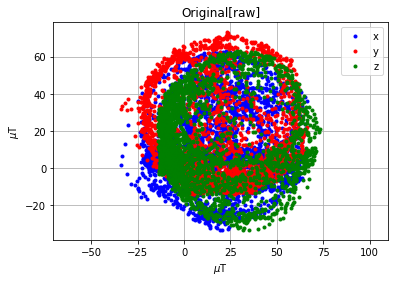

In [19]:
plotMagnetometer(orig, "Original[raw]")

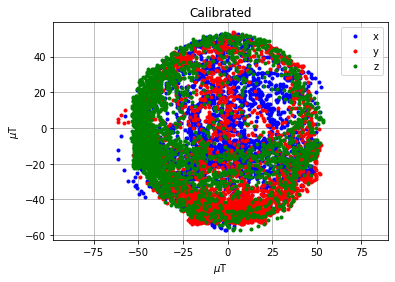

In [20]:
plotMagnetometer(cm, "Calibrated")

# Save Parameters

In [21]:
M = np.vstack((A,b))
print(M)

params = {}
params["imu"] = "Adafruit NXP"
params["timestamp"] = datetime.now()
params["mag"] = M.tolist()
params["shape"] = M.shape

storage.write("magnetometer.yaml", params)

[[ 1.136  0.014 -0.01 ]
 [ 0.014  1.144 -0.006]
 [-0.01  -0.006  1.234]
 [20.283 16.526 29.552]]


In [22]:
def plotMagnetometer(data):
    x = [v[0] for v in data]
    rx = (max(x)-min(x))/2
    cx = min(x)+rx
    
    y = [v[1] for v in data]
    ry = (max(y)-min(y))/2
    cy = min(y)+ry
    
    z = [v[2] for v in data]
    rz = (max(z)-min(z))/2
    cz = min(z)+rz
    
    alpha = 0.1
    u = np.linspace(0, 2 * np.pi, 100)
    
    plt.plot(rx*np.cos(u)+cx, ry*np.sin(u)+cy,'-r',label='xy')
    plt.plot(x,y,'.r',alpha=alpha)
    
    plt.plot(rx*np.cos(u)+cx, rz*np.sin(u)+cz,'-g',label='xz')
    plt.plot(x,z,'.g',alpha=alpha)
    
    plt.plot(rz*np.cos(u)+cz, ry*np.sin(u)+cy,'-b',label='zy')
    plt.plot(z,y, '.b',alpha=alpha)
    
    plt.title(f"CM:({cx:.1f}, {cy:.1f}, {cz:.1f}) uT  R:({rx:.1f}, {ry:.1f}, {rz:.1f}) uT")
    plt.xlabel('$\mu$T')
    plt.ylabel('$\mu$T')
    plt.grid(True);
    plt.axis('equal')
    plt.legend();

>> A:
[[ 1.136  0.014 -0.01 ]
 [ 0.014  1.144 -0.006]
 [-0.01  -0.006  1.234]]
>> b: [20.283 16.526 29.552]


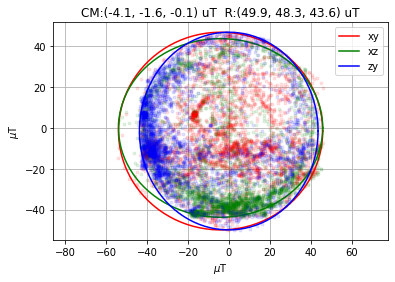

In [23]:
A, b = calibrate(magg,uT)
print(f">> A:\n{A}")
print(f">> b: {b}")

cm=(np.dot((magg-b),np.eye(3)))
plotMagnetometer(cm)